# Yale Hydropower Model

## Rocky River Powerplant

In [209]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import datetime, calendar
import random

In [197]:
# Load data
stream_flow_data_path = './data/StreamFlowData.csv'
stream_flow_df = pd.read_csv(stream_flow_data_path)
stream_flow_df = stream_flow_df.drop(['Unnamed: 0', 'agency_cd', 'site_no', 'X_00060_00003_cd'], axis=1)
stream_flow_df = stream_flow_df.rename(columns={"Date":"Date", "X_00060_00003":"CFS"})
stream_flow_df['Date'] = pd.to_datetime(stream_flow_df['Date'], format='%m/%d/%Y')
# filter out 1993-2021
df_stream = stream_flow_df[(stream_flow_df['Date'] >= '1993-01-01') & (stream_flow_df['Date'] < '2022-01-01')]
df_stream = df_stream[~((df_stream.Date.dt.month == 2) & (df_stream.Date.dt.day == 29))]

In [198]:
# df_stream = df_stream.set_index('Date')
CFS = list(df_stream['CFS'])
Dates = list(df_stream['Date'])

In [199]:
def find_minima(s):
    n = len(s)
    minima_loc = [0]
    for i in range(1, n - 1):
        if s[i] <= s[i - 1] and s[i] <= s[i + 1]:
            minima_loc.append(i)
    minima_loc.append(n-1)
    return minima_loc

def interpolate_minima(s, minima):
    new_s = []
    for i in range(len(minima) - 1):
        diff = s[minima[i + 1]] - s[minima[i]]
        interval = diff / (minima[i + 1] - minima[i])
        for j in range(minima[i + 1] - minima[i]):
            new_s.append(s[minima[i]] + j * interval)
    new_s.append(s[-1])
    return new_s

In [200]:
CFS_minima = find_minima(CFS)
CFS_interpolated = interpolate_minima(CFS, CFS_minima)
CFS_years = []
CFS_interpolated_years = []
CFS_net_years = []
counter = 0
base_year = 1993
year_nums = []
for i in range(int(len(CFS) / 365)):
    year = []
    year_interp = []
    net_flow = 0
    for j in range(365):
        year.append(CFS[counter])
        year_interp.append(CFS_interpolated[counter])
        net_flow += CFS[counter]
        counter += 1
    CFS_years.append(year)
    CFS_interpolated_years.append(year_interp)
    CFS_net_years.append(net_flow)
    year_nums.append(base_year + i)

In [201]:
sf_data = []
for i, y in enumerate(year_nums):
    sf_data.append((y, CFS_net_years[i], CFS_years[i], CFS_interpolated_years[i]))
sorted_data = sorted(sf_data, key=lambda x: x[1], reverse=True)

In [202]:
print(len(sorted_data))
Q1 = []
Q4 = []
for i in range(8):
    Q1.append(sorted_data[-(i + 1)])
    Q4.append(sorted_data[i])

# print("Q1")
# for i in range(8):
#     print(Q1[i][0], Q1[i][1])

# print("Q4")
# for i in range(8):
#     print(Q4[i][0], Q4[i][1])

29


In [203]:
Q1_ave_baseflow = []
Q4_ave_baseflow = []
for d in range(365):
    Q1_ave = 0.0
    Q4_ave = 0.0
    for y in range(8):
        Q1_ave += Q1[y][3][d]
        Q4_ave += Q4[y][3][d]
    Q1_ave_baseflow.append(Q1_ave / 8.0)
    Q4_ave_baseflow.append(Q4_ave / 8.0)

In [204]:
def residual_dist(quartile):
    residuals = []
    for year_data in quartile:
        for d in range(len(year_data[2])):
            r = year_data[2][d] - year_data[3][d]
            if r > 1.0:
                residuals.append(r)
    return residuals

In [205]:
Q1_residuals = residual_dist(Q1)
Q4_residuals = residual_dist(Q4)

<AxesSubplot: ylabel='Density'>

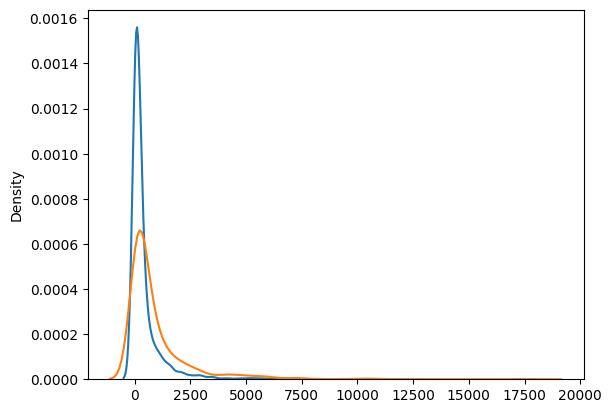

In [224]:
# print(len(Q1_residuals))
# print(len(Q4_residuals))
# print(min(Q1_residuals), max(Q1_residuals))
# print(min(Q4_residuals), max(Q4_residuals))
sns.kdeplot(Q1_residuals)
sns.kdeplot(Q4_residuals)
# x1 = np.arange(0, len(Q1_residuals), 1)
# plt.scatter(x1, sorted(Q1_residuals), marker='.', color='orange')
# x2 = np.arange(0, len(Q4_residuals), 1)
# plt.scatter(x2, sorted(Q4_residuals), marker='.', color='blue')

In [217]:
def gen_data(baseflow, noise):
    prop_add = len(noise) / 8 / 365
    baseflow_n = len(baseflow)
    new_data = []
    for d in range(365):
        new_val = baseflow[d]
        # if random.random() < prop_add:
        #     new_val += noise[random.randint(0, baseflow_n - 1)]
        new_data.append(new_val)
    return new_data


In [218]:
Q1_new = gen_data(Q1_ave_baseflow, Q1_residuals)
Q4_new = gen_data(Q4_ave_baseflow, Q4_residuals)

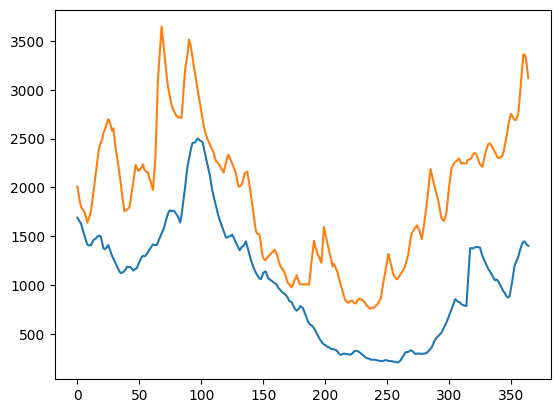

In [219]:
x = np.arange(0, 365, 1)
plt.plot(x, Q1_new)
plt.plot(x, Q4_new)

In [216]:
print(sum(Q1_new), sum(Q4_new))

469739.13975134055 1052431.565615515
